In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import seaborn as sns
from LabUtils.Utils import mkdirifnotexists

In [11]:
from LabData.DataAnalyses.TenK_Trajectories.biological_age.predict_age import work_dir, pred_dir, \
        modality_name_mapping, add_text_at_corner, male_color, female_color
sex_colors = {'Male': male_color, 'Female': female_color}
#     work_dir, pred_dir, pred_residuals_fig_dir, load_ranked_residuals, Ys_dir, sm, r2_score, \
#     BodyMeasuresLoader, add_text_at_corner
# sex_class_dir = os.path.join(work_dir, 'sex_classification')
loess_dir = os.path.join(work_dir, 'sex_specific_corrs', 'loess')

In [3]:
fig_dir = mkdirifnotexists(os.path.join(work_dir, 'figures', 'figure4'))

In [104]:
from scipy.cluster.hierarchy import cut_tree, linkage
from scipy.spatial.distance import pdist

def cluster_loess_lipids(x_name='blood_lipids', cut_tree_height=9, norm_per_sex=False):
    
    loess_dic = {}
    y_dic = {}

    
    frac = 1. / 3

    for gender in ['male', 'female']:
        x_loess = pd.read_csv(os.path.join(loess_dir, '%s_%s_equal-loess_frac%0.2f.csv' % (x_name, gender, frac)),
                              index_col=0).astype(float)
        y = pd.read_csv(os.path.join(loess_dir, '%s_%s_equal-age.csv' % (x_name, gender)), index_col=0)

        y_dic[gender] = y

        loess_dic[gender] = x_loess


    gender = 'female'
    df_f = loess_dic['female'].T.dropna().astype(float).copy()
    df_m = loess_dic['male'].T.dropna().astype(float).copy()
    if norm_per_sex:
        df_f = df_f.apply(lambda x: x - x.mean(), axis=1)
        df_m = df_m.apply(lambda x: x - x.mean(), axis=1)
    df = pd.concat((df_f, df_m), axis=1).dropna()

    df.columns = [np.round(c, 2) for c in df.columns]

    dist_df = pdist(df, metric='euclidean')
    linkage_df = linkage(dist_df, 'complete')
    labels_df = pd.Series(cut_tree(linkage_df, height=cut_tree_height).ravel(), index=df.index)
    print(labels_df.value_counts())
    labels_df = labels_df.replace({j: i for i, j in enumerate(labels_df.value_counts().index)}).sort_values()
    print(labels_df.value_counts())
#     return
    labels_df = labels_df.loc[labels_df.isin(labels_df.value_counts()[labels_df.value_counts()>1].index)]
    df = df.loc[labels_df.index]
    labels_df.value_counts()
    if norm_per_sex:
        labels_df.to_csv(os.path.join(loess_dir, '%s_labels_df_norm_per_sex.csv' % x_name))
    else:
        labels_df.to_csv(os.path.join(loess_dir, '%s_labels_df.csv' % x_name))
    df_clustered = df * np.nan
    df_clustered_list = []
    for gr in labels_df.value_counts().index:
        print(gr)
        if df.loc[labels_df == gr].shape[0] > 1:
            cg1 = sns.clustermap(df.loc[labels_df == gr], xticklabels=False, yticklabels=False, metric='euclidean',
                                 col_cluster=False)
            plt.clf()
#             df_clustered.loc[labels_df == gr, :] = df.loc[labels_df == gr].iloc[cg1.dendrogram_row.reordered_ind,
#                                                    :].values
            df_clustered_list.append(df.loc[labels_df == gr].iloc[cg1.dendrogram_row.reordered_ind, :])
        else:
            pass
            # df_clustered.loc[labels_df == gr, :] = df.loc[labels_df == gr]
    df_clustered = pd.concat(df_clustered_list, axis=0)
    df_clustered.dropna(inplace=True)
    return df_clustered, labels_df, df_f, df_m, df


from matplotlib.gridspec import GridSpec
import met_brewer


def plot_heatmaps(df_clustered, labels_df, df_f, df_m, df, vmin=-1, vmax=1):



    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(16, 20, hspace=0.05)

    ax_heatmap_f = fig.add_subplot(gs[0:5, 1:10])
    ax_heatmap_m = fig.add_subplot(gs[0:5, 10:19])
    ax_heatmap_colorbar = fig.add_subplot(gs[1:4, 19])
    ax_label = fig.add_subplot(gs[0:5, 0])
    

    sns.heatmap(df_clustered.iloc[:, :df_f.shape[1]], vmax=vmax, vmin=vmin, center=0, cmap='RdBu_r',
                ax=ax_heatmap_f, yticklabels=False, cbar=False, xticklabels=True)
    sns.heatmap(df_clustered.iloc[:, df_f.shape[1]:], vmax=vmax, vmin=vmin, center=0, cmap='RdBu_r',
                ax=ax_heatmap_m, yticklabels=False, cbar=False, xticklabels=True)
    clb = plt.colorbar(ax_heatmap_f.get_children()[0], cax=ax_heatmap_colorbar, orientation="vertical",
                       ticks=np.arange(vmin, vmax+0.5, 0.5), aspect=20)
    clb.ax.set_ylabel('z score', fontsize=15)
    ax_heatmap_f.set_xticklabels([int(c) if c in np.arange(40, 75, 5) else '' for c in df.columns[:df_f.shape[1]]],
                                 rotation=0, ha='center', fontsize=15)
    ax_heatmap_f.xaxis.set_ticks_position('none')
    ax_heatmap_f.set_title('Female lipid trajectories', fontsize=15)
    ax_heatmap_f.set_xlabel('Age (years)', fontsize=15)
    ax_heatmap_m.set_xticklabels([int(c) if c in np.arange(40, 75, 5) else '' for c in df.columns[df_f.shape[1]:]],
                                 rotation=0, ha='center', fontsize=15)
    ax_heatmap_m.xaxis.set_ticks_position('none')
    ax_heatmap_m.set_title('Male lipid trajectories', fontsize=15)
    ax_heatmap_m.set_xlabel('Age (years)', fontsize=15)

    colors = met_brewer.met_brew(name="Monet", n=labels_df.max() + 1, brew_type="continuous")
    sns.heatmap(pd.DataFrame(labels_df), cmap=colors, ax=ax_label, yticklabels=False, xticklabels=False, cbar=False)
    ax_label.set_ylabel('Lipid cluster', fontsize=15)
    ax_label.set_yticks([])
    ax_label.text(-0.6, 1.0, 'a', ha='center', va='center', transform=ax_label.transAxes, fontsize=30, weight='bold')

    def plot_cluster(c_id, ax, df_f, df_m, labels_df):
        for gender, df in zip(['Female', 'Male'], [df_f, df_m]):
            bottom = df.loc[labels_df[labels_df == c_id].index].quantile(0.1)
            upper = df.loc[labels_df[labels_df == c_id].index].quantile(0.9)
            middle = df.loc[labels_df[labels_df == c_id].index].quantile(0.5)
            ax.plot(df.columns, middle, label=gender, color=sex_colors[gender])
            ax.fill_between(df.columns, bottom, upper, alpha=0.5, color=sex_colors[gender])
            ax.set_ylim(vmin, vmax)
            ax.set_title('Cluster %d' % (c_id + 1), fontsize=15)
            ax.set_yticks(np.arange(vmin, vmax+0.5, 0.5))
            add_text_at_corner(ax, 'n=%d' % (labels_df == c_id).sum(), 'top left')
            ax.tick_params(labelsize=15)

#         ax.legend(loc='lower left')
    
    for c_id, x1, x2, y1, y2, l, xlabel, ylabel in zip(range(6),
                                    [7, 7, 7, 12, 12, 12],
                                    [11, 11, 11, 16, 16, 16],
                                    [1, 8, 15, 1, 8, 15],
                                    [6, 13, 20, 6, 13, 20], 
                                    ['b', 'c', 'd', 'e', 'f', 'g'], 
                                    ['', '', '', 'Age (years)', 'Age (years)', 'Age (years)'],
                                    ['z score', '', '', 'z score', '', '']):
        ax = fig.add_subplot(gs[x1:x2, y1:y2])
        plot_cluster(c_id, ax, df_clustered.iloc[:, :df_f.shape[1]], df_clustered.iloc[:, df_f.shape[1]:], labels_df)
        ax.text(-0.3, 1.0, l, ha='center', va='center', transform=ax.transAxes, fontsize=30, weight='bold')
        ax.set_xlabel(xlabel, fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        ax.set_xticks([40, 50, 60, 70], fontsize=15)
        if l == 'f':
            ax.legend(ncol=2, bbox_to_anchor=(0.5, -0.5), fancybox=True, fontsize=15, loc='lower center')
    return 


In [6]:
df_clustered, labels_df, df_f, df_m, df = cluster_loess_lipids()

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

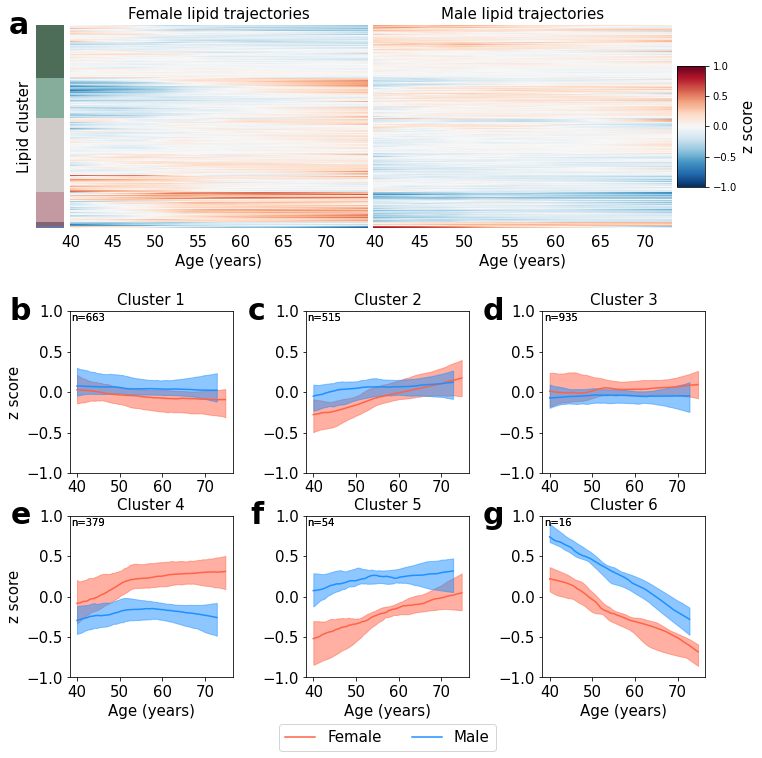

In [14]:
plot_heatmaps(df_clustered, labels_df, df_f, df_m, df)

plt.savefig(os.path.join(fig_dir, 'figure4.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure4.pdf'), dpi=300, bbox_inches='tight')

In [105]:
df_clustered, labels_df, df_f, df_m, df = cluster_loess_lipids(x_name='blood_lipids', 
                                                               cut_tree_height=5.3, norm_per_sex=True) # 5.3

0    1093
2     601
3     347
1     255
6     246
5      20
4       1
dtype: int64
0    1093
1     601
2     347
3     255
4     246
5      20
6       1
dtype: int64
0


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


1


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


2


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


3


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


4


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


5


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

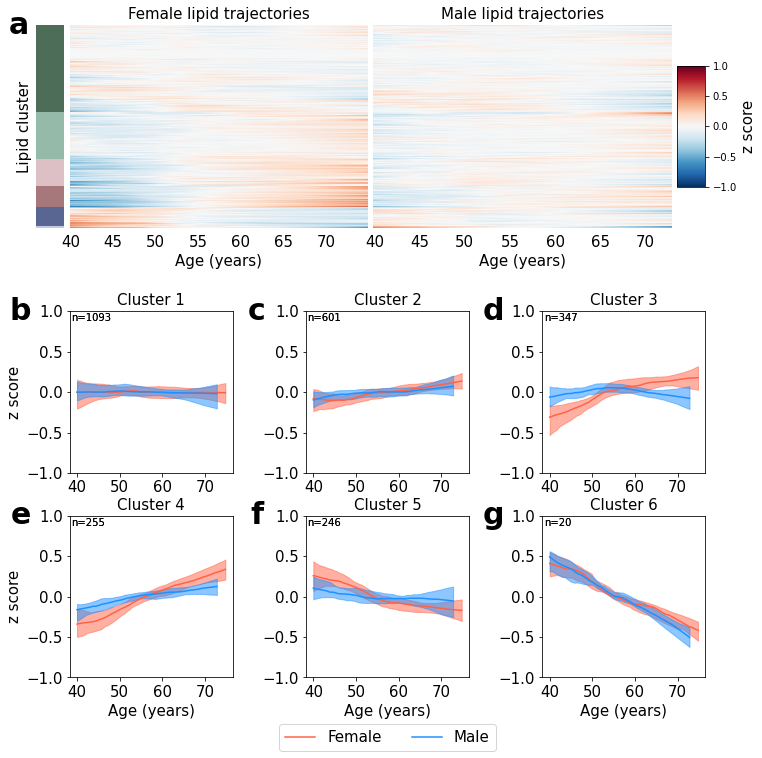

In [106]:
plot_heatmaps(df_clustered, labels_df, df_f, df_m, df, vmin=-1, vmax=1)

In [76]:
mb_df_clustered, mb_labels_df, mb_df_f, mb_df_m, mb_df = cluster_loess_lipids(x_name='microbiome', cut_tree_height=4)
mb_labels_df.value_counts()

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


1    239
3    182
0    146
4     19
5     15
2     12
dtype: int64

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

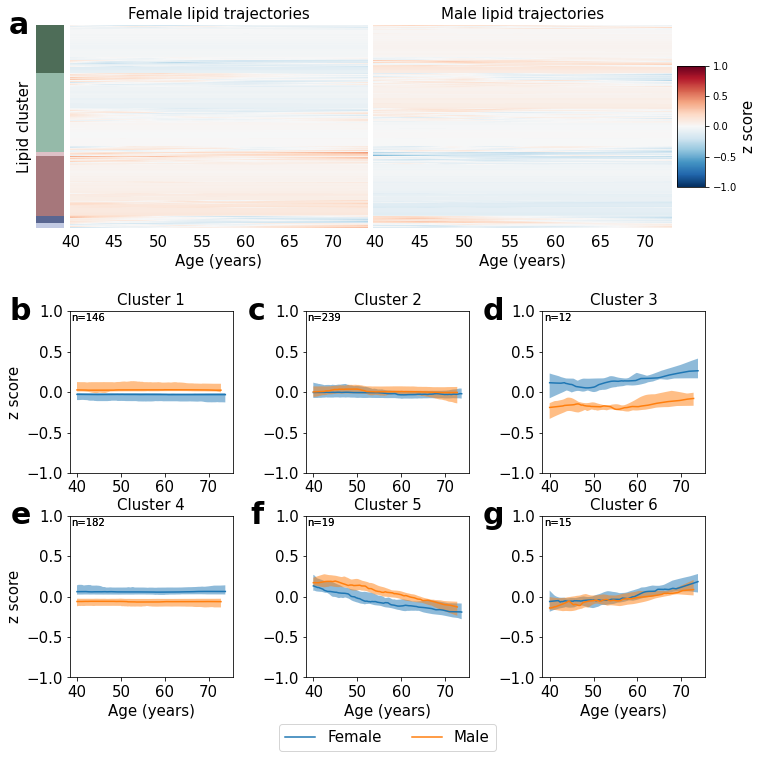

In [77]:
plot_heatmaps(mb_df_clustered, mb_labels_df, mb_df_f, mb_df_m, mb_df)


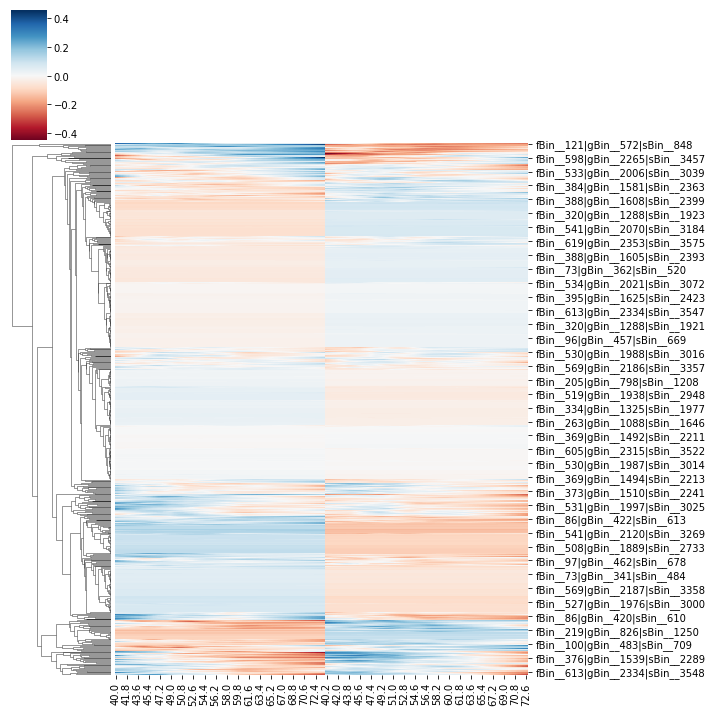

In [69]:
sns.clustermap(mb_df, col_cluster=False, center=0, cmap='RdBu')